In [ ]:
!pip install chess


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chess
import seaborn as sns
import chess.pgn

pd.set_option('display.max_columns', 500)
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
pal = sns.color_palette()

<ipython-input-2-e3f95c350057>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


#Chess Data Analysis Using Python

In this Notebook, I will attempt to:
1. Look at the general trends from the archive of games.
2. Review top pairings and players.
3. Use the chess python package to review a game
4. Use the stockfish engine to analyze a game position
5. See if we can successfully catch someone who might be using an engine during games.

Our dataset is a collection of all professional chess games played from the year 2012.



# 1. General Chess Trends

In [ ]:
df = pd.read_csv('/twic_master.csv')
#df  = pd.read_parquet('/content/twic_master.parquet')

<ipython-input-3-591427cd8c04>:1: DtypeWarning: Columns (10,13,14,23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/twic_master.csv')


In [ ]:
df.head()

#Which players occur the most in the archive?

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))
pd.concat([df['White'], df['Black']]).value_counts(ascending=True).tail(20).plot(kind='barh',
                    ax=ax)
ax.set_title('Players with most games played', fontsize=20)
plt.show()

#What we the top openings used each year?

In [ ]:
#change dtype of date to datetime
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

In [ ]:
df['Year'].value_counts()

In [ ]:
df = df.query('2023 > Year > 2012')

#query taking too long to run
#df.groupby(["Year", "Opening"]).value_counts()

In [ ]:
df.groupby(["Year", "Opening"]).size().unstack()

In [ ]:
df['Year'].unique().sort()

In [ ]:
#myyear = 2018
#
for myyear in range(2013, 2023):
    df.query('Year == @myyear')['Opening'].value_counts(ascending = True).tail(5).plot(kind = 'barh', title = myyear)
    plt.show()

#sicilian is a clear choice for most chess players
#does not quite help us as there is not much change over the years

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(15,8))
axs = axs.flatten()

for i, myyear in enumerate(range(2013, 2023)):
    df.query('Year == @myyear')['Opening'].value_counts(ascending = True).tail(5).plot(kind = 'barh', title = myyear,ax = axs[i])
plt.tight_layout()
plt.show()


#What % of the games were played online and how many were played over-the-board?

In [ ]:
df['Week'] = df['Date'].dt.isocalendar().week

In [ ]:
df = df.sort_values('Date')
df

In [ ]:
df['Online']

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
df.groupby(['Year', 'Week'])['Online'].mean().plot(title = '% of games played online')
plt.show()

**Clear effects of the Covid-19 virus can be seen as almost all games were played online starting from late-2019 up until early-2022.**

#Use chess package to review games

- Find the game with the biggest upset.


In [ ]:
df_elo = df.dropna(subset=['BlackElo', 'WhiteElo']).astype({'BlackElo': int, 'WhiteElo' : int}).copy()
df_elo['Elo_diff'] = (df_elo['BlackElo'] - df_elo['WhiteElo'])
df_elo['Elo_diff']

In [ ]:
df_elo.head()

<Axes: ylabel='Frequency'>

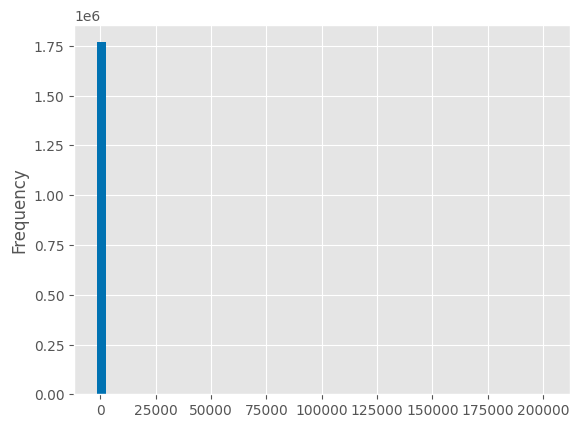

In [ ]:
df_elo['Elo_diff'].plot(kind='hist', bins=50)

In [ ]:
#df_elo['Elo_diff'].max()
#df_elo.loc[df_elo['Elo_diff'] == 201942]
df_elo = df_elo.drop(1662955)

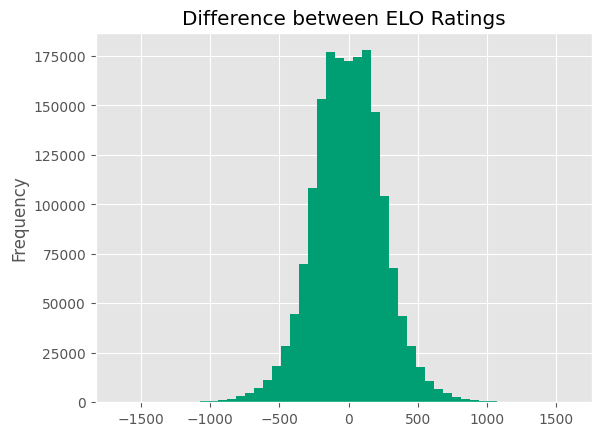

In [ ]:
ax = df_elo['Elo_diff'].plot(kind='hist', bins=50, title = 'Difference between ELO Ratings', color = pal[1])
ax.set_xlabel('ELO Difference')
plt.show()

In [ ]:
df_elo[['WhiteElo', 'BlackElo', 'Elo_diff', 'Result']]

,WhiteElo,BlackElo,Elo_diff,Result
1503145,2037,1792,-245,1-0
1504605,2113,2274,161,1/2-1/2
1504603,2234,2313,79,1/2-1/2
1504602,2322,2195,-127,1-0
1503852,2178,2006,-172,1-0
...,...,...,...,...
1866687,2336,2519,183,1/2-1/2
1866685,2387,2437,50,1/2-1/2
1866684,2422,2478,56,1/2-1/2
1866692,2526,2331,-195,1-0


In [ ]:
df_elo['WhiteIsRatedHigher'] = df_elo['WhiteElo'] > df_elo['BlackElo']

In [ ]:
df_upsets = (
    df_elo.query("(WhiteIsRatedHigher and Result == '0-1') or (not WhiteIsRatedHigher and Result == '1-0')"
    ).reset_index(drop=True).copy()
)

In [ ]:
df_upsets[['WhiteElo', 'BlackElo', 'Elo_diff', 'Result']]

,WhiteElo,BlackElo,Elo_diff,Result
0,1940,2158,218,1-0
1,2245,2094,-151,0-1
2,2547,2148,-399,0-1
3,2102,2315,213,1-0
4,1964,2013,49,1-0
...,...,...,...,...
333477,2491,2358,-133,0-1
333478,2510,2521,11,1-0
333479,2044,2352,308,1-0
333480,2214,2513,299,1-0


In [ ]:
#upsets across all ELO levels
ax = df_upsets['Elo_diff'].plot(
    kind='hist',
    bins=50,
    title = 'Difference between ELO Ratings for Upsets',
    color = pal[2])
ax.set_xlabel('ELO Difference')
plt.show()

In [ ]:
df_upsets.loc[df_upsets[['WhiteElo', 'BlackElo']].max(axis=1) > 2500]

In [ ]:
#upsets across all ELO levels
ax = df_upsets.loc[df_upsets[['WhiteElo', 'BlackElo']].max(axis=1) > 2500]['Elo_diff'].plot(
    kind='hist',
    bins=50,
    title = 'Difference between ELO Ratings for Upsets for 2000+ ELO',
    color = pal[2])

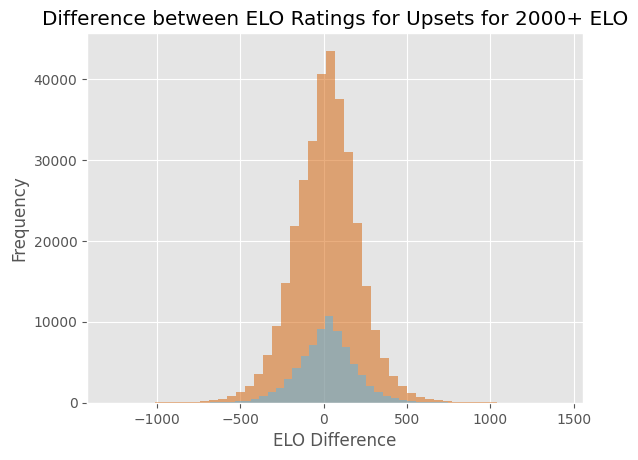

In [ ]:
#try and get a better understanding of both graphs by plotting them on top of each other
ax = df_upsets['Elo_diff'].plot(
    kind='hist',
    bins=50,
    title = 'Difference between ELO Ratings for Upsets',
    color = pal[2],
    alpha = 0.5)
#ax.set_xlabel('ELO Difference')

ax = df_upsets.loc[df_upsets[['WhiteElo', 'BlackElo']].max(axis=1) > 2500]['Elo_diff'].plot(
    kind='hist',
    bins=50,
    title = 'Difference between ELO Ratings for Upsets for 2000+ ELO',
    color = pal[5],
    alpha = 0.5)

ax.set_xlabel('ELO Difference')
plt.show()
ax.set_xlabel('ElO Difference')
plt.show()

<Axes: title={'center': 'Difference between ELO Ratings for Upsets for 2000+ ELO'}, ylabel='Frequency'>

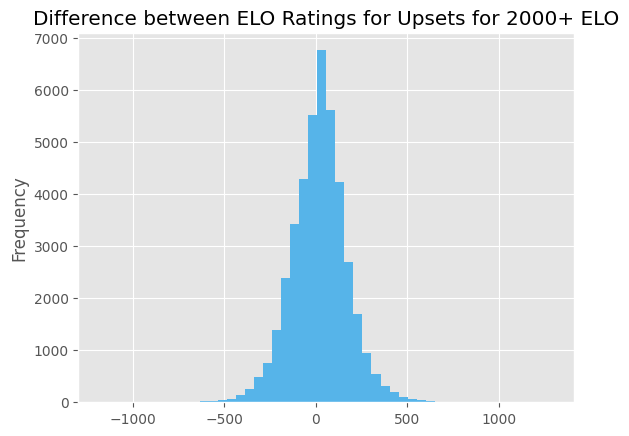

In [ ]:
#let us take a look at some of these upsets but only for over the board games
df_upsets.loc[df_upsets[['WhiteElo', 'BlackElo']].max(axis=1) > 2500].query(
    'Online == False')['Elo_diff'].plot(
        kind='hist',
        bins=50,
        title = 'Difference between ELO Ratings for Upsets for 2000+ ELO',
        color = pal[5],
        #alpha = 0.5
    )

